Level 2
Task 3: Forest Cover Type Classification

Description:


*   Dataset (Recommended): Covertype (UCI).
*   Predict the type of forest cover based on cartographic and environmental features.
*   Clean and preprocess the data including categorical handling.
*   Train and evaluate multi-class classification models.
*   Visualize confusion matrix and feature importance.







Tools & Libraries:


*   Python
*   Pandas
*   Scikit-Learn
*   XGBoost


Covered Topics:


*   Multi-class classification
*   Tree-based modeling






Bonus:


*   Compare different models (e.g., Random Forest vs. XGBoost).
*   Perform hyperparameter tuning.



In [2]:
import pandas as pd
from sklearn.datasets import fetch_covtype
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
covtype = fetch_covtype(as_frame=True)
X = covtype.data
Y = covtype.target

print(X.head())
print(Y.value_counts())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2          234.0           238.0   

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9526254643507694

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     25238
           2       0.95      0.97      0.96     34136
           3       0.94      0.96      0.95      4268
           4       0.91      0.85      0.88       339
           5       0.95      0.79      0.86      1152
           6       0.93      0.90      0.91      2130
           7       0.97      0.94      0.96      2458

    accuracy                           0.95     69721
   macro avg       0.94      0.91      0.92     69721
weighted avg       0.95      0.95      0.95     69721



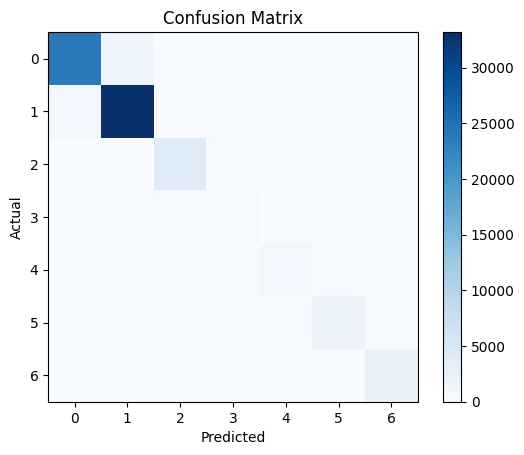

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

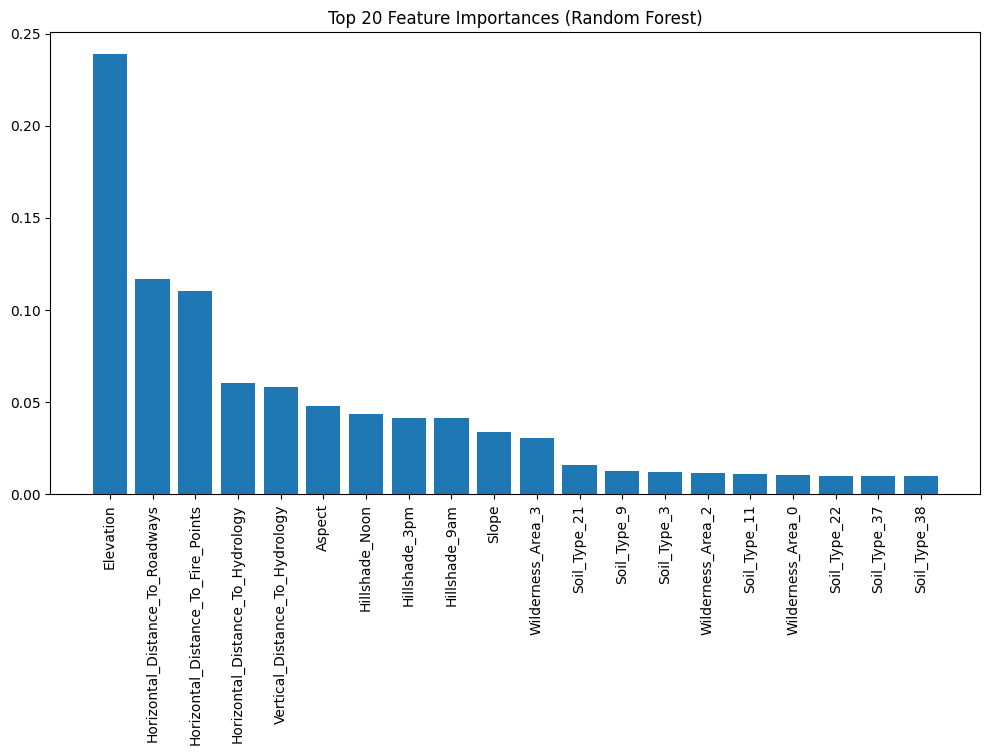

In [ ]:
# Pair each feature index with its importance
indexed_importances = list(enumerate(rf.feature_importances_))

# Sort by importance (descending)
sorted_importances = sorted(indexed_importances, key=lambda x: x[1], reverse=True)

# Take the top 20
top20 = sorted_importances[:20]

# Split into indices and values
indices = [i for i, _ in top20]
importances_top = [val for _, val in top20]

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(20), importances_top, align="center")
plt.xticks(range(20), [X.columns[i] for i in indices], rotation=90)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

Data Cleaning and Preprocessing

In [ ]:
# Check for missing values
print(X.isnull().sum().sum())

# If missing values exist (unlikely here), fill or drop
X = X.fillna(X.median())

0


In [ ]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = [c for c in X.columns if "Soil_Type" in c or "Wilderness_Area" in c]

print("Numeric:", len(numeric_cols))
print("Categorical:", len(categorical_cols))


Numeric: 54
Categorical: 44


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", "passthrough", categorical_cols)  # keep 0/1 values
    ]
)

In [ ]:
Y = Y - 1

In [ ]:
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

pipeline.fit(x_train, y_train)
print("Accuracy:", pipeline.score(x_test, y_test))

Accuracy: 0.9487385436238723


In [ ]:
models = {
    "LogReg (multinomial)": LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=500, n_jobs=None
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVC (RBF)": SVC(kernel="rbf", C=3.0, gamma="scale", random_state=42),
    "KNN (k=15)": KNeighborsClassifier(n_neighbors=15, weights="distance"),
}

In [ ]:
def evaluate_model(name, estimator):
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", estimator)
    ])
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    print(f"\n=== {name} ===")
    print(f"Accuracy:        {acc:.4f}")
    print(f"F1 (macro):      {f1_macro:.4f}")
    print(f"F1 (weighted):   {f1_weighted:.4f}")
    print("\nPer-class report:")
    print(classification_report(y_test, y_pred, digits=3))

    # Normalized confusion matrix (by true class)
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(cm, display_labels=sorted(Y.unique()))
    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
    ax.set_title(f"Normalized Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

    return pipe, acc, f1_macro, f1_weighted

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg (multinomial) ===
Accuracy:        0.7236
F1 (macro):      0.5290
F1 (weighted):   0.7139

Per-class report:
              precision    recall  f1-score   support

           1      0.708     0.697     0.703     25238
           2      0.750     0.799     0.774     34136
           3      0.674     0.803     0.733      4268
           4      0.623     0.410     0.495       339
           5      0.136     0.005     0.010      1152
           6      0.494     0.267     0.346      2130
           7      0.719     0.581     0.643      2458

    accuracy                          0.724     69721
   macro avg      0.586     0.509     0.529     69721
weighted avg      0.710     0.724     0.714     69721



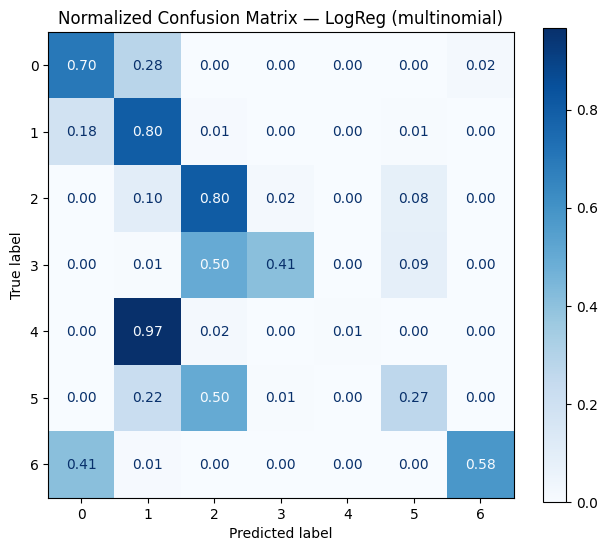


=== RandomForest ===
Accuracy:        0.9495
F1 (macro):      0.9197
F1 (weighted):   0.9493

Per-class report:
              precision    recall  f1-score   support

           1      0.960     0.935     0.947     25238
           2      0.944     0.971     0.957     34136
           3      0.940     0.956     0.948      4268
           4      0.905     0.844     0.873       339
           5      0.948     0.769     0.849      1152
           6      0.930     0.890     0.909      2130
           7      0.967     0.941     0.954      2458

    accuracy                          0.950     69721
   macro avg      0.942     0.901     0.920     69721
weighted avg      0.950     0.950     0.949     69721



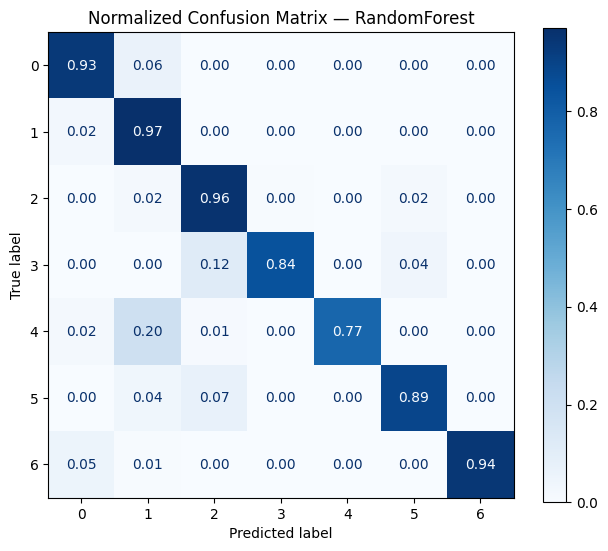


=== GradientBoosting ===
Accuracy:        0.7728
F1 (macro):      0.6820
F1 (weighted):   0.7687

Per-class report:
              precision    recall  f1-score   support

           1      0.759     0.748     0.754     25238
           2      0.785     0.827     0.805     34136
           3      0.751     0.832     0.790      4268
           4      0.798     0.723     0.759       339
           5      0.777     0.234     0.359      1152
           6      0.648     0.453     0.533      2130
           7      0.850     0.712     0.775      2458

    accuracy                          0.773     69721
   macro avg      0.767     0.647     0.682     69721
weighted avg      0.772     0.773     0.769     69721



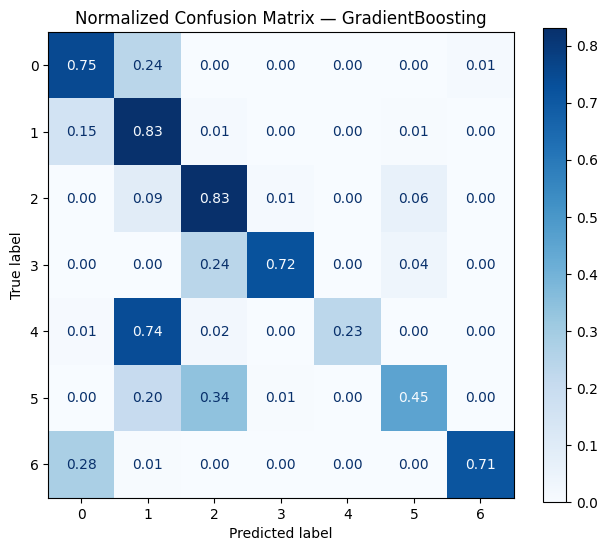


=== SVC (RBF) ===
Accuracy:        0.8053
F1 (macro):      0.6771
F1 (weighted):   0.7997

Per-class report:
              precision    recall  f1-score   support

           1      0.816     0.762     0.788     25238
           2      0.804     0.877     0.839     34136
           3      0.768     0.863     0.813      4268
           4      0.811     0.507     0.624       339
           5      0.847     0.182     0.300      1152
           6      0.692     0.474     0.562      2130
           7      0.865     0.767     0.813      2458

    accuracy                          0.805     69721
   macro avg      0.800     0.633     0.677     69721
weighted avg      0.806     0.805     0.800     69721



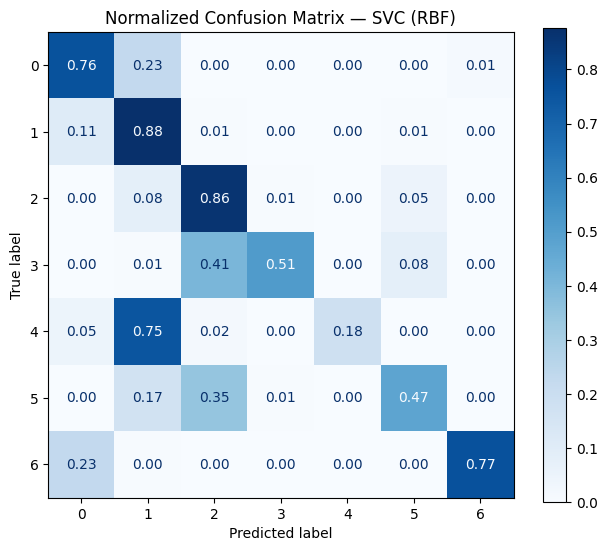


=== KNN (k=15) ===
Accuracy:        0.9176
F1 (macro):      0.8541
F1 (weighted):   0.9172

Per-class report:
              precision    recall  f1-score   support

           1      0.931     0.907     0.919     25238
           2      0.922     0.945     0.933     34136
           3      0.879     0.897     0.888      4268
           4      0.836     0.676     0.747       339
           5      0.836     0.719     0.773      1152
           6      0.802     0.790     0.796      2130
           7      0.925     0.921     0.923      2458

    accuracy                          0.918     69721
   macro avg      0.876     0.836     0.854     69721
weighted avg      0.917     0.918     0.917     69721



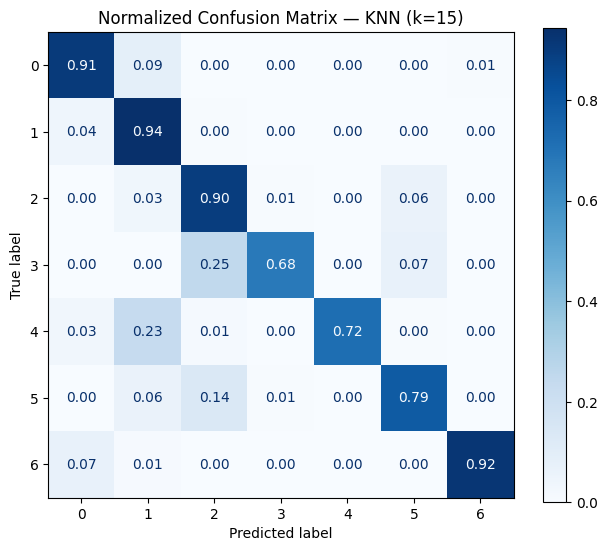


=== Summary (sorted by Macro F1) ===
               model  accuracy  f1_macro  f1_weighted
        RandomForest  0.949542  0.919735     0.949285
          KNN (k=15)  0.917586  0.854145     0.917240
    GradientBoosting  0.772766  0.682031     0.768741
           SVC (RBF)  0.805310  0.677097     0.799723
LogReg (multinomial)  0.723570  0.529015     0.713860


In [ ]:
results = []
fitted_models = {}
for name, est in models.items():
    pipe, acc, f1m, f1w = evaluate_model(name, est)
    fitted_models[name] = pipe
    results.append({"model": name, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w})

# 8) Summary table
summary = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False)
print("\n=== Summary (sorted by Macro F1) ===")
print(summary.to_string(index=False))


Working on 500 Rows only

In [ ]:
# 1) Column names
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = ["Cover_Type"]

all_cols = cont_cols + wilderness_cols + soil_cols + target_col

# 2) Load dataset (gzip compressed CSV, no header)
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)

# 3) Features/target
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

# 4) Collapse one-hot into single categorical (optional)
df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1
df["Soil"] = df[soil_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1

X = df[cont_cols + ["Wilderness","Soil"]]
y = df["Cover_Type"]

# 5) Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6) Preprocessor
preprocessor = ColumnTransformer([
    ("cont", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), cont_cols),
    ("cat", "passthrough", ["Wilderness","Soil"])
])

# Example pipeline with a classifier (RandomForest, LogisticRegression, etc.)


<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:30: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3297002767.py:29: SyntaxWarning: invalid escape sequence '\d'
  df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1
/tmp/ipython-input-3297002767.py:30: SyntaxWarning: invalid escape sequence '\d'
  df["Soil"] = df[soil_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1


In [ ]:
# ===== small stratified sample + LR & XGBoost =====

# 1) Column names (UCI)
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]   # 4 binary
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]        # 40 binary
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

# 2) Load full data (gzipped CSV without header)
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)

# --- Stratified sampling to ~500 rows (ensures ≥2 per class for stratify) ---
n_classes = df[target_col].nunique()              # 7
per_class = max(5, min(80, 500 // n_classes))     # ~70 per class → ~490 rows
df_small = (
    df.groupby(target_col, group_keys=False)
      .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
      .reset_index(drop=True)
)

# 3) Collapse one-hot groups → compact integer categories (for tree models)
df_small["Wilderness"] = df_small[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1
df_small["Soil"]       = df_small[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1

# Two feature views
X_linear = df_small[cont_cols + wilderness_cols + soil_cols]   # one-hot for linear models
X_tree   = df_small[cont_cols + ["Wilderness","Soil"]]         # compact ints for XGBoost
y        = df_small[target_col]                                # labels 1..7 (UCI)

# 4) Train–test splits (stratified)
Xlin_tr, Xlin_te, y_tr, y_te = train_test_split(
    X_linear, y, test_size=0.2, stratify=y, random_state=42
)
Xtree_tr, Xtree_te, y_tr_tree, y_te_tree = train_test_split(
    X_tree, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Convert labels to 0..6 for XGBoost ONLY ----
y_tr0 = (y_tr_tree - 1).astype(int)
y_te0 = (y_te_tree - 1).astype(int)

# 5a) Logistic Regression pipeline (scale continuous, passthrough binaries)
preprocess_linear = ColumnTransformer([
    ("scale_cont", StandardScaler(), cont_cols),
    ("pass_bins", "passthrough", wilderness_cols + soil_cols),
])
logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# 5b) XGBoost (light params for small sample; speed-friendly)
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

# 6) Train & evaluate
def evaluate_lr():
    logreg.fit(Xlin_tr, y_tr)                   # LR uses original 1..7 labels
    y_pred = logreg.predict(Xlin_te)
    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average="macro")
    print("\n=== Logistic Regression ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Macro F1   : {f1m:.4f}")
    print("\nClassification report:")
    print(classification_report(y_te, y_pred))
    return acc, f1m

def evaluate_xgb():
    xgb.fit(Xtree_tr, y_tr0)                    # XGB on 0..6 labels
    y_pred = xgb.predict(Xtree_te)
    acc = accuracy_score(y_te0, y_pred)
    f1m = f1_score(y_te0, y_pred, average="macro")
    print("\n=== XGBoost (0-based labels) ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Macro F1   : {f1m:.4f}")
    print("\nClassification report:")
    print(classification_report(y_te0, y_pred, digits=4))
    return acc, f1m

acc_lr, f1_lr = evaluate_lr()
acc_xg, f1_xg = evaluate_xgb()

print("\nBest model:",
      "XGBoost" if f1_xg >= f1_lr else "Logistic Regression",
      f"(XGB={f1_xg:.4f}, LR={f1_lr:.4f})")


/tmp/ipython-input-3311617162.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression ===
Accuracy   : 0.6100
Macro F1   : 0.5887

Classification report:
              precision    recall  f1-score   support

           1       0.33      0.36      0.34        14
           2       0.29      0.14      0.19        14
           3       0.64      0.64      0.64        14
           4       0.88      0.93      0.90        15
           5       0.69      0.64      0.67        14
           6       0.62      0.71      0.67        14
           7       0.63      0.80      0.71        15

    accuracy                           0.61       100
   macro avg       0.58      0.60      0.59       100
weighted avg       0.59      0.61      0.59       100


=== XGBoost (0-based labels) ===
Accuracy   : 0.6700
Macro F1   : 0.6594

Classification report:
              precision    recall  f1-score   support

           0     0.4167    0.3571    0.3846        14
           1     0.5455    0.4286    0.4800        14
           2     0.6429    0.6429    0.6429      

In [ ]:
# ===== small sample + LR & XGBoost + confusion matrix & importances =====

# 1) Column names (UCI)
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

# 2) Load + stratified sample (~500 rows total)
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)
n_classes = df[target_col].nunique()             # 7
per_class = max(5, min(80, 500 // n_classes))    # ~70 per class ≈ 490 rows
df_small = (
    df.groupby(target_col, group_keys=False)
      .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
      .reset_index(drop=True)
)

# 3) Collapse one-hot groups → compact integer categories (for tree models)
df_small["Wilderness"] = df_small[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1
df_small["Soil"]       = df_small[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1

# Two feature views
X_linear = df_small[cont_cols + wilderness_cols + soil_cols]   # good for linear models
X_tree   = df_small[cont_cols + ["Wilderness","Soil"]]         # compact for XGBoost
y        = df_small[target_col]                                # labels 1..7 (UCI)

# 4) Train–test splits (stratified)
Xlin_tr, Xlin_te, y_tr, y_te = train_test_split(
    X_linear, y, test_size=0.2, stratify=y, random_state=42
)
Xtree_tr, Xtree_te, y_tr_tree, y_te_tree = train_test_split(
    X_tree, y, test_size=0.2, stratify=y, random_state=42
)

# XGBoost requires labels 0..K-1
y_tr0 = (y_tr_tree - 1).astype(int)
y_te0 = (y_te_tree - 1).astype(int)

# 5a) Logistic Regression pipeline (scale continuous, passthrough binaries)
preprocess_linear = ColumnTransformer([
    ("scale_cont", StandardScaler(), cont_cols),
    ("pass_bins", "passthrough", wilderness_cols + soil_cols),
])
logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# 5b) XGBoost (light params for small sample)
xgb = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

# 6) Train & evaluate Logistic Regression
logreg.fit(Xlin_tr, y_tr)              # LR keeps original 1..7 labels
y_pred_lr = logreg.predict(Xlin_te)
print("\n=== Logistic Regression ===")
print("Accuracy:", f"{accuracy_score(y_te, y_pred_lr):.4f}")
print("Macro F1:", f"{f1_score(y_te, y_pred_lr, average='macro'):.4f}")
print(classification_report(y_te, y_pred_lr))

# 7) Train & evaluate XGBoost (0-based labels)
xgb.fit(Xtree_tr, y_tr0)
y_pred_xgb = xgb.predict(Xtree_te)
print("\n=== XGBoost ===")
print("Accuracy:", f"{accuracy_score(y_te0, y_pred_xgb):.4f}")
print("Macro F1:", f"{f1_score(y_te0, y_pred_xgb, average='macro'):.4f}")
print(classification_report(y_te0, y_pred_xgb, digits=4))

# 8) Confusion matrix (as a pandas table, no plotting libs)
cm = confusion_matrix(y_te0, y_pred_xgb, labels=list(range(n_classes)))
cm_df = pd.DataFrame(cm,
                     index=[f"true_{i+1}" for i in range(n_classes)],
                     columns=[f"pred_{i+1}" for i in range(n_classes)])
print("\nConfusion Matrix (XGBoost):")
print(cm_df)

# 9) Feature importance (XGBoost) as a sorted table
importances = pd.Series(xgb.feature_importances_, index=Xtree_tr.columns)
feat_table = importances.sort_values(ascending=False).head(20)
print("\nTop 20 Feature Importances (XGBoost):")
print(feat_table)


/tmp/ipython-input-48528311.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression ===
Accuracy: 0.6100
Macro F1: 0.5887
              precision    recall  f1-score   support

           1       0.33      0.36      0.34        14
           2       0.29      0.14      0.19        14
           3       0.64      0.64      0.64        14
           4       0.88      0.93      0.90        15
           5       0.69      0.64      0.67        14
           6       0.62      0.71      0.67        14
           7       0.63      0.80      0.71        15

    accuracy                           0.61       100
   macro avg       0.58      0.60      0.59       100
weighted avg       0.59      0.61      0.59       100


=== XGBoost ===
Accuracy: 0.6600
Macro F1: 0.6473
              precision    recall  f1-score   support

           0     0.3636    0.2857    0.3200        14
           1     0.5455    0.4286    0.4800        14
           2     0.6429    0.6429    0.6429        14
           3     0.7857    0.7333    0.7586        15
           4     0

In [ ]:
# ===== small sample + LR & XGBoost + confusion matrices & importances =====

# 1) Column names (UCI)
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

# 2) Load + stratified sample (~500 rows total)
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)
n_classes = df[target_col].nunique()             # 7
per_class = max(5, min(80, 500 // n_classes))    # ~70 per class ≈ 490 rows
df_small = (
    df.groupby(target_col, group_keys=False)
      .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
      .reset_index(drop=True)
)

# 3) Collapse one-hot groups → compact integer categories (for tree models)
df_small["Wilderness"] = df_small[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1
df_small["Soil"]       = df_small[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1

# Two feature views
X_linear = df_small[cont_cols + wilderness_cols + soil_cols]   # for Logistic Regression
X_tree   = df_small[cont_cols + ["Wilderness","Soil"]]         # for XGBoost
y        = df_small[target_col]                                # labels 1..7 (UCI)

# 4) Train–test splits (stratified)
Xlin_tr, Xlin_te, y_tr, y_te = train_test_split(
    X_linear, y, test_size=0.2, stratify=y, random_state=42
)
Xtree_tr, Xtree_te, y_tr_tree, y_te_tree = train_test_split(
    X_tree, y, test_size=0.2, stratify=y, random_state=42
)

# XGBoost requires labels 0..K-1
y_tr0 = (y_tr_tree - 1).astype(int)
y_te0 = (y_te_tree - 1).astype(int)

# 5a) Logistic Regression pipeline (scale continuous, passthrough binaries)
preprocess_linear = ColumnTransformer([
    ("scale_cont", StandardScaler(), cont_cols),
    ("pass_bins", "passthrough", wilderness_cols + soil_cols),
])
logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# 5b) XGBoost (light params for small sample)
xgb = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

# 6) Train & evaluate Logistic Regression
logreg.fit(Xlin_tr, y_tr)              # LR keeps original 1..7 labels
y_pred_lr = logreg.predict(Xlin_te)
print("\n=== Logistic Regression ===")
print("Accuracy:", f"{accuracy_score(y_te, y_pred_lr):.4f}")
print("Macro F1:", f"{f1_score(y_te, y_pred_lr, average='macro'):.4f}")
print(classification_report(y_te, y_pred_lr))

# ---- Confusion matrix (LR) as a pandas table ----
classes_lr = sorted(y.unique())  # [1..7]
cm_lr = confusion_matrix(y_te, y_pred_lr, labels=classes_lr)
cm_lr_df = pd.DataFrame(cm_lr,
                        index=[f"true_{c}" for c in classes_lr],
                        columns=[f"pred_{c}" for c in classes_lr])
print("\nConfusion Matrix (Logistic Regression):")
print(cm_lr_df)

# ---- Feature importance (LR) via coefficients ----
# Get feature names in the order seen by the model after preprocessing
feat_names_trans = logreg.named_steps["prep"].get_feature_names_out()
# Strip "transformer__" prefixes for readability
feat_names = [name.split("__", 1)[1] if "__" in name else name for name in feat_names_trans]

# Coefficients: shape (n_classes, n_features)
coefs = logreg.named_steps["clf"].coef_
coef_df = pd.DataFrame(coefs, columns=feat_names,
                       index=[f"class_{c}" for c in logreg.named_steps["clf"].classes_])

print("\nLogistic Regression Coefficients (per class) — first 5 columns:")
print(coef_df.iloc[:, :5])  # preview

# Global importance = mean absolute coefficient across classes
lr_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False)
print("\nTop 20 Feature Importances (Logistic Regression; mean |coef| across classes):")
print(lr_importance.head(20))

# 7) Train & evaluate XGBoost (0-based labels)
xgb.fit(Xtree_tr, y_tr0)
y_pred_xgb = xgb.predict(Xtree_te)
print("\n=== XGBoost ===")
print("Accuracy:", f"{accuracy_score(y_te0, y_pred_xgb):.4f}")
print("Macro F1:", f"{f1_score(y_te0, y_pred_xgb, average='macro'):.4f}")
print(classification_report(y_te0, y_pred_xgb, digits=4))

# ---- Confusion matrix (XGBoost) as a pandas table ----
cm_xgb = confusion_matrix(y_te0, y_pred_xgb, labels=list(range(n_classes)))
cm_xgb_df = pd.DataFrame(cm_xgb,
                         index=[f"true_{i+1}" for i in range(n_classes)],
                         columns=[f"pred_{i+1}" for i in range(n_classes)])
print("\nConfusion Matrix (XGBoost):")
print(cm_xgb_df)

# ---- Feature importance (XGBoost) as a sorted table ----
xgb_importances = pd.Series(xgb.feature_importances_, index=Xtree_tr.columns)
xgb_feat_table = xgb_importances.sort_values(ascending=False).head(20)
print("\nTop 20 Feature Importances (XGBoost):")
print(xgb_feat_table)


/tmp/ipython-input-2617257001.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression ===
Accuracy: 0.6100
Macro F1: 0.5887
              precision    recall  f1-score   support

           1       0.33      0.36      0.34        14
           2       0.29      0.14      0.19        14
           3       0.64      0.64      0.64        14
           4       0.88      0.93      0.90        15
           5       0.69      0.64      0.67        14
           6       0.62      0.71      0.67        14
           7       0.63      0.80      0.71        15

    accuracy                           0.61       100
   macro avg       0.58      0.60      0.59       100
weighted avg       0.59      0.61      0.59       100


Confusion Matrix (Logistic Regression):
        pred_1  pred_2  pred_3  pred_4  pred_5  pred_6  pred_7
true_1       5       3       0       0       1       0       5
true_2       8       2       0       0       1       1       2
true_3       0       1       9       2       0       2       0
true_4       0       0       0      14       0 

In [ ]:
# ===== compare Logistic Regression, Random Forest, XGBoost =====

# 1) Column names (UCI)
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

# 2) Load + stratified sample (~500 rows total)
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)
n_classes = df[target_col].nunique()             # 7
per_class = max(5, min(80, 500 // n_classes))    # ~70 per class ≈ 490 rows
df_small = (
    df.groupby(target_col, group_keys=False)
      .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
      .reset_index(drop=True)
)

# 3) Collapse one-hot groups → compact integer categories (for tree models)
df_small["Wilderness"] = df_small[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1
df_small["Soil"]       = df_small[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1

# Two feature views
X_linear = df_small[cont_cols + wilderness_cols + soil_cols]   # for Logistic Regression
X_tree   = df_small[cont_cols + ["Wilderness","Soil"]]         # for RF & XGB
y        = df_small[target_col]                                # labels 1..7 (UCI)

# 4) Train–test splits (stratified)
Xlin_tr, Xlin_te, y_tr, y_te = train_test_split(
    X_linear, y, test_size=0.2, stratify=y, random_state=42
)
Xtree_tr, Xtree_te, y_tr_tree, y_te_tree = train_test_split(
    X_tree, y, test_size=0.2, stratify=y, random_state=42
)

# For XGBoost: labels must be 0..K-1
y_tr0 = (y_tr_tree - 1).astype(int)
y_te0 = (y_te_tree - 1).astype(int)

# 5a) Logistic Regression pipeline
preprocess_linear = ColumnTransformer([
    ("scale_cont", StandardScaler(), cont_cols),
    ("pass_bins", "passthrough", wilderness_cols + soil_cols),
])
logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# 5b) Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

# 5c) XGBoost
xgb = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

# 6) Evaluation helper
def evaluate(name, model, X_tr, y_tr, X_te, y_te, label_shift=False):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average="macro")
    print(f"\n=== {name} ===")
    print("Accuracy:", f"{acc:.4f}")
    print("Macro F1:", f"{f1m:.4f}")
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred, labels=sorted(pd.Series(y_te).unique()))
    cm_df = pd.DataFrame(cm,
                         index=[f"true_{c}" for c in sorted(pd.Series(y_te).unique())],
                         columns=[f"pred_{c}" for c in sorted(pd.Series(y_te).unique())])
    print("\nConfusion Matrix:")
    print(cm_df)
    return model, acc, f1m

# 7) Run Logistic Regression
lr_model, acc_lr, f1_lr = evaluate("Logistic Regression", logreg, Xlin_tr, y_tr, Xlin_te, y_te)

# 8) Run Random Forest
rf_model, acc_rf, f1_rf = evaluate("Random Forest", rf, Xtree_tr, y_tr_tree, Xtree_te, y_te_tree)

# 9) Run XGBoost (0-based labels)
xgb.fit(Xtree_tr, y_tr0)
y_pred_xgb = xgb.predict(Xtree_te)
acc_xg = accuracy_score(y_te0, y_pred_xgb)
f1_xg  = f1_score(y_te0, y_pred_xgb, average="macro")
print("\n=== XGBoost ===")
print("Accuracy:", f"{acc_xg:.4f}")
print("Macro F1:", f"{f1_xg:.4f}")
print(classification_report(y_te0, y_pred_xgb, digits=4))
cm_xgb = confusion_matrix(y_te0, y_pred_xgb, labels=list(range(n_classes)))
cm_xgb_df = pd.DataFrame(cm_xgb,
                         index=[f"true_{i+1}" for i in range(n_classes)],
                         columns=[f"pred_{i+1}" for i in range(n_classes)])
print("\nConfusion Matrix (XGBoost):")
print(cm_xgb_df)

# 10) Feature importances
# LR: mean |coef| across classes
feat_names_lr = [name.split("__", 1)[1] if "__" in name else name
                 for name in logreg.named_steps["prep"].get_feature_names_out()]
coefs = logreg.named_steps["clf"].coef_
coef_df = pd.DataFrame(coefs, columns=feat_names_lr,
                       index=[f"class_{c}" for c in logreg.named_steps["clf"].classes_])
lr_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances (Logistic Regression):")
print(lr_importance)

# RF: Gini importances
rf_importances = pd.Series(rf_model.feature_importances_, index=Xtree_tr.columns)
print("\nTop 10 Feature Importances (Random Forest):")
print(rf_importances.sort_values(ascending=False).head(10))

# XGB: gain importances
xgb_importances = pd.Series(xgb.feature_importances_, index=Xtree_tr.columns)
print("\nTop 10 Feature Importances (XGBoost):")
print(xgb_importances.sort_values(ascending=False).head(10))

# 11) Summary
print("\n=== Model Comparison Summary ===")
print(f"Logistic Regression: Acc={acc_lr:.4f}, F1={f1_lr:.4f}")
print(f"Random Forest      : Acc={acc_rf:.4f}, F1={f1_rf:.4f}")
print(f"XGBoost            : Acc={acc_xg:.4f}, F1={f1_xg:.4f}")


/tmp/ipython-input-1709743108.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(per_class, len(g)), random_state=42))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression ===
Accuracy: 0.6100
Macro F1: 0.5887
              precision    recall  f1-score   support

           1       0.33      0.36      0.34        14
           2       0.29      0.14      0.19        14
           3       0.64      0.64      0.64        14
           4       0.88      0.93      0.90        15
           5       0.69      0.64      0.67        14
           6       0.62      0.71      0.67        14
           7       0.63      0.80      0.71        15

    accuracy                           0.61       100
   macro avg       0.58      0.60      0.59       100
weighted avg       0.59      0.61      0.59       100


Confusion Matrix:
        pred_1  pred_2  pred_3  pred_4  pred_5  pred_6  pred_7
true_1       5       3       0       0       1       0       5
true_2       8       2       0       0       1       1       2
true_3       0       1       9       2       0       2       0
true_4       0       0       0      14       0       1       0
true_5

Hyperparameters worth tuning



1.   Logistic Regression


*   C (inverse regularization strength)
*   penalty (L1 vs L2)


2.   Random Forest


*   n_estimators (trees)
*   max_depth
*   min_samples_split
*   max_features



3.   XGBoost


*   n_estimators
*   max_depth
*   learning_rate
*   subsample
*   colsample_bytree


In [ ]:
# ===== hyperparameter tuning =====

# ---------- 1) Load + build features ----------
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)

# collapse one-hot blocks → compact integer categories (good for trees)
df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1
df["Soil"]       = df[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype(int) - 1

# two views
X_linear_full = df[cont_cols + wilderness_cols + soil_cols]         # for LR
X_tree_full   = df[cont_cols + ["Wilderness","Soil"]]               # for RF/XGB
y_full        = df[target_col]
y_full0       = (y_full - 1).astype(int)                            # 0..6 for XGB

# ---------- 2) Take a stratified sample for tuning (≈5k rows) ----------
sample_size = 5000
df_idx = (
    df.groupby(target_col, group_keys=False)
      .apply(lambda g: g.sample(n=min(max(100, sample_size // df[target_col].nunique()), len(g)),
                                random_state=42))
      .index
)
X_linear = X_linear_full.loc[df_idx]
X_tree   = X_tree_full.loc[df_idx]
y_lin    = y_full.loc[df_idx]
y_tree   = y_full.loc[df_idx]
y_tree0  = (y_tree - 1).astype(int)

# quick train/holdout split for the final score preview
Xlin_tr, Xlin_te, ylin_tr, ylin_te = train_test_split(
    X_linear, y_lin, test_size=0.2, stratify=y_lin, random_state=42
)
Xtr_tr,  Xtr_te,  ytr_tr,  ytr_te  = train_test_split(
    X_tree,   y_tree, test_size=0.2, stratify=y_tree, random_state=42
)
ytr_tr0, ytr_te0 = (ytr_tr - 1).astype(int), (ytr_te - 1).astype(int)

# ---------- 3) Define pipelines/models ----------
# Logistic Regression (multinomial) on one-hot view
preprocess_linear = ColumnTransformer([
    ("scale_cont", StandardScaler(), cont_cols),
    ("pass_bins", "passthrough", wilderness_cols + soil_cols),
])
logreg_pipe = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial", solver="saga", max_iter=300, n_jobs=-1
    ))
])

# Random Forest on compact view
rf = RandomForestClassifier(
    n_jobs=-1, random_state=42, class_weight="balanced_subsample"
)

# XGBoost on compact view (0-based labels later)
xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",       # use "gpu_hist" if you have a GPU
    n_jobs=-1,
    random_state=42
)

# ---------- 4) Parameter spaces ----------
param_dist_lr = {
    "clf__C":       [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    "clf__penalty": ["l1", "l2"]
}

param_dist_rf = {
    "n_estimators":   [100, 150, 200, 300, 400],
    "max_depth":      [None, 8, 12, 16, 20, 30],
    "min_samples_split": [2, 4, 6, 8, 10],
    "max_features":   ["sqrt", "log2", None]
}

param_dist_xgb = {
    "n_estimators":      [150, 250, 350, 450],
    "max_depth":         [3, 4, 5, 6, 8, 10],
    "learning_rate":     [0.02, 0.05, 0.08, 0.1, 0.15],
    "subsample":         [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":  [0.7, 0.8, 0.9, 1.0]
}

# ---------- 5) RandomizedSearchCV (n_iter controls runtime) ----------
search_lr  = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist_lr,
    n_iter=12,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1
)
search_rf  = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=12,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1
)
search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=12,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1
)

# ---------- 6) Run searches ----------
search_lr.fit(Xlin_tr, ylin_tr)
print("\nBest Logistic Regression Params:", search_lr.best_params_)

search_rf.fit(Xtr_tr, ytr_tr)
print("Best Random Forest Params:", search_rf.best_params_)

search_xgb.fit(Xtr_tr, ytr_tr0)  # 0-based labels for XGB
print("Best XGBoost Params:", search_xgb.best_params_)

# ---------- 7) Quick hold-out evaluation with best estimators ----------
def eval_model(name, est, X_te, y_te):
    yp = est.predict(X_te)
    acc = accuracy_score(y_te, yp)
    f1m = f1_score(y_te, yp, average="macro")
    print(f"\n{name} — Hold-out Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
    print(classification_report(y_te, yp))
    return acc, f1m

acc_lr, f1_lr = eval_model("LogReg (best)", search_lr.best_estimator_, Xlin_te, ylin_te)
acc_rf, f1_rf = eval_model("RandomForest (best)", search_rf.best_estimator_, Xtr_te, ytr_te)
# XGB: evaluate on 0-based labels
acc_xg, f1_xg = eval_model("XGBoost (best)", search_xgb.best_estimator_, Xtr_te, ytr_te0)

print("\n=== Summary (hold-out) ===")
print(f"LogReg : Acc={acc_lr:.4f}, F1m={f1_lr:.4f}")
print(f"RF     : Acc={acc_rf:.4f}, F1m={f1_rf:.4f}")
print(f"XGBoost: Acc={acc_xg:.4f}, F1m={f1_xg:.4f}")


/tmp/ipython-input-1988375727.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(max(100, sample_size // df[target_col].nunique()), len(g)),
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Best Logistic Regression Params: {'clf__penalty': 'l2', 'clf__C': 10}
Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 20}
Best XGBoost Params: {'subsample': 0.9, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.08, 'colsample_bytree': 0.9}

LogReg (best) — Hold-out Accuracy: 0.6950 | Macro F1: 0.6905
              precision    recall  f1-score   support

           1       0.66      0.62      0.64       142
           2       0.61      0.53      0.57       143
           3       0.61      0.52      0.56       143
           4       0.77      0.87      0.82       143
           5       0.74      0.78      0.76       143
           6       0.59      0.64      0.61       143
           7       0.85      0.90      0.87       143

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000


RandomForest (best) — Hold-ou

Working on the Whole Dataset

In [ ]:
# 1) Column names
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = ["Cover_Type"]

all_cols = cont_cols + wilderness_cols + soil_cols + target_col

# 2) Load dataset (gzip compressed CSV, no header)
#df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)
df = pd.read_csv("covtype.data.gz", compression="infer", header=None, names=all_cols)

# 3) Features/target
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

# 4) Collapse one-hot into single categorical (optional)
df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1
df["Soil"] = df[soil_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1

X = df[cont_cols + ["Wilderness","Soil"]]
y = df["Cover_Type"]

# 5) Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6) Preprocessor
preprocessor = ColumnTransformer([
    ("cont", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), cont_cols),
    ("cat", "passthrough", ["Wilderness","Soil"])
])

# Example pipeline with a classifier (RandomForest, LogisticRegression, etc.)


<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2903125148.py:30: SyntaxWarning: invalid escape sequence '\d'
  df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1
/tmp/ipython-input-2903125148.py:31: SyntaxWarning: invalid escape sequence '\d'
  df["Soil"] = df[soil_cols].idxmax(axis=1).str.extract("(\d+)").astype(int) - 1


In [ ]:
# ===== FULL DATA + LR & XGBoost + confusion matrices & importances =====
import pandas as pd
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
from xgboost import XGBClassifier

# 1) Column names (UCI)
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

# 2) Load FULL data (gzipped CSV without header) and downcast to save RAM
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)
for c in cont_cols: df[c] = df[c].astype("float32")
for c in wilderness_cols + soil_cols: df[c] = df[c].astype("int8")
df[target_col] = df[target_col].astype("int8")

n_classes = df[target_col].nunique()  # should be 7

# 3) Collapse one-hot groups → compact integer categories (for tree models)
df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1
df["Soil"]       = df[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1

# Two feature views
X_linear = df[cont_cols + wilderness_cols + soil_cols]    # for Logistic Regression
X_tree   = df[cont_cols + ["Wilderness","Soil"]]          # for XGBoost
y        = df[target_col]                                 # labels 1..7

# 4) Train–test splits (FULL data, stratified)
Xlin_tr, Xlin_te, y_tr, y_te = train_test_split(
    X_linear, y, test_size=0.2, stratify=y, random_state=42
)
Xtree_tr, Xtree_te, y_tr_tree, y_te_tree = train_test_split(
    X_tree, y, test_size=0.2, stratify=y, random_state=42
)

# XGBoost requires labels 0..K-1
y_tr0 = (y_tr_tree - 1).astype("int8")
y_te0 = (y_te_tree - 1).astype("int8")

# 5a) Logistic Regression pipeline (scale continuous, passthrough binaries)
preprocess_linear = ColumnTransformer(
    transformers=[
        ("scale_cont", StandardScaler(), cont_cols),
        ("pass_bins", "passthrough", wilderness_cols + soil_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# 5b) XGBoost base params (we'll do manual early stopping)
base_params = dict(
    max_depth=8,
    learning_rate=0.07,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",     # use "gpu_hist" if there is a GPU
    n_jobs=-1,
    random_state=42
)
# Make a small validation split from the XGBoost training fold
Xtr_xgb, Xval_xgb, ytr_xgb, yval_xgb = train_test_split(
    Xtree_tr, y_tr0, test_size=0.1, stratify=y_tr0, random_state=42
)

# 6) Train & evaluate Logistic Regression (FULL)
logreg.fit(Xlin_tr, y_tr)
y_pred_lr = logreg.predict(Xlin_te)
print("\n=== Logistic Regression (FULL) ===")
print("Accuracy:", f"{accuracy_score(y_te, y_pred_lr):.4f}")
print("Macro F1:", f"{f1_score(y_te, y_pred_lr, average='macro'):.4f}")
print(classification_report(y_te, y_pred_lr))

# Confusion matrix (LR) as a table
classes_lr = sorted(y.unique())  # [1..7]
cm_lr = confusion_matrix(y_te, y_pred_lr, labels=classes_lr)
cm_lr_df = pd.DataFrame(cm_lr,
                        index=[f"true_{c}" for c in classes_lr],
                        columns=[f"pred_{c}" for c in classes_lr])
print("\nConfusion Matrix (Logistic Regression):")
print(cm_lr_df)

# LR feature importance via coefficients
feat_names_trans = logreg.named_steps["prep"].get_feature_names_out()
feat_names = [name.split("__", 1)[1] if "__" in name else name for name in feat_names_trans]
coefs = logreg.named_steps["clf"].coef_  # shape: (n_classes, n_features)
coef_df = pd.DataFrame(coefs, columns=feat_names,
                       index=[f"class_{c}" for c in logreg.named_steps["clf"].classes_])
lr_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False)
print("\nTop 20 Feature Importances (Logistic Regression; mean |coef| across classes):")
print(lr_importance.head(20))

# 7) Train & evaluate XGBoost (FULL) — MANUAL early stopping (compatible with old xgboost)
max_estimators = 2000
step = 200           # add trees in chunks
patience = 5         # stop after 5 non-improving steps
no_improve = 0
best_loss = float("inf")
best_model = None
best_iter  = 0
booster    = None    # for incremental training

cur_estimators = 0
while cur_estimators < max_estimators and no_improve < patience:
    cur_estimators += step
    # train up to cur_estimators, continuing from previous booster if available
    xgb_tmp = XGBClassifier(n_estimators=cur_estimators, **base_params)
    if booster is not None:
        xgb_tmp.fit(Xtr_xgb, ytr_xgb, xgb_model=booster, verbose=False)
    else:
        xgb_tmp.fit(Xtr_xgb, ytr_xgb, verbose=False)

    # Evaluate on validation
    proba_val = xgb_tmp.predict_proba(Xval_xgb)
    loss = log_loss(yval_xgb, proba_val, labels=list(range(n_classes)))

    if loss + 1e-6 < best_loss:
        best_loss = loss
        best_model = copy.deepcopy(xgb_tmp)  # keep a full copy of the sklearn wrapper
        best_iter  = cur_estimators
        no_improve = 0
        booster    = xgb_tmp.get_booster()   # continue from here next loop
        # print(f"Improved at {cur_estimators} trees: val mlogloss={loss:.5f}")
    else:
        no_improve += 1
        # print(f"No improvement at {cur_estimators} trees (val mlogloss={loss:.5f})")

# Fallback if never improved (shouldn't happen)
if best_model is None:
    best_model = xgb_tmp
    best_iter  = cur_estimators

# Use the best saved model for test predictions
y_pred_xgb = best_model.predict(Xtree_te)

print("\n=== XGBoost (FULL, manual early stopping) ===")
print("Best iteration:", best_iter)
print("Accuracy     :", f"{accuracy_score(y_te0, y_pred_xgb):.4f}")
print("Macro F1     :", f"{f1_score(y_te0, y_pred_xgb, average='macro'):.4f}")
print(classification_report(y_te0, y_pred_xgb, digits=4))

# Confusion matrix (XGBoost) as a table (labels 0..6 → display 1..7)
cm_xgb = confusion_matrix(y_te0, y_pred_xgb, labels=list(range(n_classes)))
cm_xgb_df = pd.DataFrame(cm_xgb,
                         index=[f"true_{i+1}" for i in range(n_classes)],
                         columns=[f"pred_{i+1}" for i in range(n_classes)])
print("\nConfusion Matrix (XGBoost):")
print(cm_xgb_df)

# XGBoost feature importance
xgb_importances = pd.Series(best_model.feature_importances_, index=Xtree_tr.columns).sort_values(ascending=False)
print("\nTop 20 Feature Importances (XGBoost):")
print(xgb_importances.head(20))

# 8) Quick winner summary
acc_lr = accuracy_score(y_te, y_pred_lr); f1_lr = f1_score(y_te, y_pred_lr, average="macro")
acc_xg = accuracy_score(y_te0, y_pred_xgb); f1_xg = f1_score(y_te0, y_pred_xgb, average="macro")
print("\nBest model:",
      "XGBoost" if f1_xg >= f1_lr else "Logistic Regression",
      f"(XGB={f1_xg:.4f}, LR={f1_lr:.4f})")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Logistic Regression (FULL) ===
Accuracy: 0.6002
Macro F1: 0.4774
              precision    recall  f1-score   support

           1       0.68      0.66      0.67     42368
           2       0.79      0.51      0.62     56661
           3       0.53      0.87      0.66      7151
           4       0.40      0.29      0.34       549
           5       0.10      0.74      0.18      1899
           6       0.31      0.32      0.31      3473
           7       0.40      0.89      0.56      4102

    accuracy                           0.60    116203
   macro avg       0.46      0.61      0.48    116203
weighted avg       0.69      0.60      0.62    116203


Confusion Matrix (Logistic Regression):
        pred_1  pred_2  pred_3  pred_4  pred_5  pred_6  pred_7
true_1   28087    7501      63       0    1655     183    4879
true_2   12702   29158    2776      26    9903    1583     513
true_3       0      19    6198     118     270     546       0
true_4       0       0     373     161  

In [ ]:
# ===== FULL DATA + LR & XGBoost + confusion matrices & importances =====

# 1) Column names (UCI)
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

# 2) Load FULL data (gzipped CSV without header) and downcast to save RAM
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)
for c in cont_cols: df[c] = df[c].astype("float32")
for c in wilderness_cols + soil_cols: df[c] = df[c].astype("int8")
df[target_col] = df[target_col].astype("int8")

n_classes = df[target_col].nunique()  # should be 7

# 3) Collapse one-hot groups → compact integer categories (for tree models)
df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1
df["Soil"]       = df[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1

# Two feature views
X_linear = df[cont_cols + wilderness_cols + soil_cols]    # for Logistic Regression
X_tree   = df[cont_cols + ["Wilderness","Soil"]]          # for XGBoost
y        = df[target_col]                                 # labels 1..7 (UCI)

# 4) Train–test splits (FULL data, stratified)
Xlin_tr, Xlin_te, y_tr, y_te = train_test_split(
    X_linear, y, test_size=0.2, stratify=y, random_state=42
)
Xtree_tr, Xtree_te, y_tr_tree, y_te_tree = train_test_split(
    X_tree, y, test_size=0.2, stratify=y, random_state=42
)

# XGBoost requires labels 0..K-1
y_tr0 = (y_tr_tree - 1).astype("int8")
y_te0 = (y_te_tree - 1).astype("int8")

# 5a) Logistic Regression pipeline (scale continuous, passthrough binaries)
preprocess_linear = ColumnTransformer(
    transformers=[
        ("scale_cont", StandardScaler(), cont_cols),
        ("pass_bins", "passthrough", wilderness_cols + soil_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# 5b) XGBoost with early stopping (validation split from training fold)
xgb = XGBClassifier(
    n_estimators=2000,          # upper bound; early stopping halts earlier
    max_depth=8,
    learning_rate=0.07,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",         # set "gpu_hist" if there is a GPU
    n_jobs=-1,
    random_state=42
)
Xtr_xgb, Xval_xgb, ytr_xgb, yval_xgb = train_test_split(
    Xtree_tr, y_tr0, test_size=0.1, stratify=y_tr0, random_state=42
)

# 6) Train & evaluate Logistic Regression (FULL)
logreg.fit(Xlin_tr, y_tr)
y_pred_lr = logreg.predict(Xlin_te)
print("\n=== Logistic Regression (FULL) ===")
print("Accuracy:", f"{accuracy_score(y_te, y_pred_lr):.4f}")
print("Macro F1:", f"{f1_score(y_te, y_pred_lr, average='macro'):.4f}")
print(classification_report(y_te, y_pred_lr))

# Confusion matrix (LR) as a pandas table
classes_lr = sorted(y.unique())  # [1..7]
cm_lr = confusion_matrix(y_te, y_pred_lr, labels=classes_lr)
cm_lr_df = pd.DataFrame(cm_lr,
                        index=[f"true_{c}" for c in classes_lr],
                        columns=[f"pred_{c}" for c in classes_lr])
print("\nConfusion Matrix (Logistic Regression):")
print(cm_lr_df)

# LR feature importance via coefficients
feat_names_trans = logreg.named_steps["prep"].get_feature_names_out()
feat_names = [name.split("__", 1)[1] if "__" in name else name for name in feat_names_trans]
coefs = logreg.named_steps["clf"].coef_  # shape: (n_classes, n_features)
coef_df = pd.DataFrame(coefs, columns=feat_names,
                       index=[f"class_{c}" for c in logreg.named_steps["clf"].classes_])
lr_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False)
print("\nTop 20 Feature Importances (Logistic Regression; mean |coef| across classes):")
print(lr_importance.head(20))

# 7) Train & evaluate XGBoost (FULL, early stopping)
xgb.fit(
    Xtr_xgb, ytr_xgb,
    eval_set=[(Xval_xgb, yval_xgb)],
    early_stopping_rounds=100,
    verbose=False
)
y_pred_xgb = xgb.predict(Xtree_te)
print("\n=== XGBoost (FULL, early stopping) ===")
print("Best iteration:", xgb.best_iteration)
print("Accuracy     :", f"{accuracy_score(y_te0, y_pred_xgb):.4f}")
print("Macro F1     :", f"{f1_score(y_te0, y_pred_xgb, average='macro'):.4f}")
print(classification_report(y_te0, y_pred_xgb, digits=4))

# Confusion matrix (XGBoost) as a pandas table (labels 0..6 → display 1..7)
cm_xgb = confusion_matrix(y_te0, y_pred_xgb, labels=list(range(n_classes)))
cm_xgb_df = pd.DataFrame(cm_xgb,
                         index=[f"true_{i+1}" for i in range(n_classes)],
                         columns=[f"pred_{i+1}" for i in range(n_classes)])
print("\nConfusion Matrix (XGBoost):")
print(cm_xgb_df)

# XGBoost feature importance
xgb_importances = pd.Series(xgb.feature_importances_, index=Xtree_tr.columns).sort_values(ascending=False)
print("\nTop 20 Feature Importances (XGBoost):")
print(xgb_importances.head(20))

# 8) Quick winner summary
acc_lr = accuracy_score(y_te, y_pred_lr); f1_lr = f1_score(y_te, y_pred_lr, average="macro")
acc_xg = accuracy_score(y_te0, y_pred_xgb); f1_xg = f1_score(y_te0, y_pred_xgb, average="macro")
print("\nBest model:",
      "XGBoost" if f1_xg >= f1_lr else "Logistic Regression",
      f"(XGB={f1_xg:.4f}, LR={f1_lr:.4f})")


In [ ]:
# ===== FULL DATA: LR vs RF vs XGBoost =====

# 1) Column names (UCI)
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

# 2) Load FULL data (gzipped CSV without header) and downcast to save RAM
df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)
for c in cont_cols: df[c] = df[c].astype("float32")
for c in wilderness_cols + soil_cols: df[c] = df[c].astype("int8")
df[target_col] = df[target_col].astype("int8")

n_classes = df[target_col].nunique()  # should be 7

# 3) Collapse one-hot groups → compact integer categories (for tree models)
df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1
df["Soil"]       = df[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1

# Two feature views
X_linear = df[cont_cols + wilderness_cols + soil_cols]     # for Logistic Regression
X_tree   = df[cont_cols + ["Wilderness","Soil"]]           # for RF & XGBoost
y        = df[target_col]                                  # labels 1..7 (UCI)
y0       = (y - 1).astype("int8")                          # 0..6 (for XGBoost only)

# 4) Stratified train/test splits (FULL data)
Xlin_tr, Xlin_te, y_tr,  y_te  = train_test_split(
    X_linear, y,  test_size=0.2, stratify=y,  random_state=42
)
Xtr_tr,  Xtr_te,  ytr,   yte   = train_test_split(
    X_tree,   y,  test_size=0.2, stratify=y,  random_state=42
)
ytr0, yte0 = (ytr - 1).astype("int8"), (yte - 1).astype("int8")  # for XGB

# 5a) Logistic Regression pipeline (scale continuous, passthrough binaries)
preprocess_linear = ColumnTransformer(
    transformers=[
        ("scale_cont", StandardScaler(), cont_cols),
        ("pass_bins", "passthrough", wilderness_cols + soil_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# 5b) Random Forest (works well on compact categories)
rf = RandomForestClassifier(
    n_estimators=400,                 # a bit higher for stability on full data
    max_depth=None,
    min_samples_split=4,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

# 5c) XGBoost with early stopping (fast & strong)
xgb = XGBClassifier(
    n_estimators=2000,               # upper bound, ES will stop early
    max_depth=8,
    learning_rate=0.07,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",              # use "gpu_hist" if there is a GPU
    n_jobs=-1,
    random_state=42
)
# Build a small validation split from the training fold for early stopping
Xtr_xgb, Xval_xgb, ytr_xgb, yval_xgb = train_test_split(
    Xtr_tr, ytr0, test_size=0.1, stratify=ytr0, random_state=42
)

# 6) Helpers
def evaluate(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    yp = model.predict(X_te)
    acc = accuracy_score(y_te, yp)
    f1m = f1_score(y_te, yp, average="macro")
    print(f"\n=== {name} ===")
    print("Accuracy:", f"{acc:.4f}")
    print("Macro F1:", f"{f1m:.4f}")
    print(classification_report(y_te, yp))
    cm = confusion_matrix(y_te, yp, labels=sorted(pd.Series(y_te).unique()))
    cm_df = pd.DataFrame(cm,
                         index=[f"true_{c}" for c in sorted(pd.Series(y_te).unique())],
                         columns=[f"pred_{c}" for c in sorted(pd.Series(y_te).unique())])
    print("\nConfusion Matrix:")
    print(cm_df)
    return model, acc, f1m

# 7) Train & evaluate Logistic Regression (FULL)
lr_model, acc_lr, f1_lr = evaluate("Logistic Regression", logreg, Xlin_tr, y_tr, Xlin_te, y_te)

# 8) Train & evaluate Random Forest (FULL)
rf_model, acc_rf, f1_rf = evaluate("Random Forest", rf, Xtr_tr, ytr, Xtr_te, yte)

# 9) Train & evaluate XGBoost (FULL, early stopping; note: 0-based labels)
xgb.fit(
    Xtr_xgb, ytr_xgb,
    eval_set=[(Xval_xgb, yval_xgb)],
    #early_stopping_rounds=100,
    verbose=False
)
yp_xgb = xgb.predict(Xtr_te)
acc_xg = accuracy_score(yte0, yp_xgb)
f1_xg  = f1_score(yte0, yp_xgb, average="macro")
print("\n=== XGBoost (early stopping) ===")
print("Best iteration:", xgb.best_iteration)
print("Accuracy:", f"{acc_xg:.4f}")
print("Macro F1:", f"{f1_xg:.4f}")
print(classification_report(yte0, yp_xgb, digits=4))
cm_xgb = confusion_matrix(yte0, yp_xgb, labels=list(range(n_classes)))
cm_xgb_df = pd.DataFrame(cm_xgb,
                         index=[f"true_{i+1}" for i in range(n_classes)],
                         columns=[f"pred_{i+1}" for i in range(n_classes)])
print("\nConfusion Matrix (XGBoost):")
print(cm_xgb_df)

# 10) Feature importances
# LR: mean |coef| across classes
feat_names_lr = [n.split("__", 1)[1] if "__" in n else n
                 for n in logreg.named_steps["prep"].get_feature_names_out()]
coefs = logreg.named_steps["clf"].coef_
coef_df = pd.DataFrame(coefs, columns=feat_names_lr,
                       index=[f"class_{c}" for c in logreg.named_steps["clf"].classes_])
lr_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False).head(15)
print("\nTop 15 Feature Importances (Logistic Regression):")
print(lr_importance)

# RF: Gini importances
rf_importances = pd.Series(rf_model.feature_importances_, index=Xtr_tr.columns)
print("\nTop 15 Feature Importances (Random Forest):")
print(rf_importances.sort_values(ascending=False).head(15))

# XGB: gain importances
xgb_importances = pd.Series(xgb.feature_importances_, index=Xtr_tr.columns)
print("\nTop 15 Feature Importances (XGBoost):")
print(xgb_importances.sort_values(ascending=False).head(15))

# 11) Summary
print("\n=== Model Comparison Summary (FULL) ===")
print(f"Logistic Regression: Acc={acc_lr:.4f}, F1={f1_lr:.4f}")
print(f"Random Forest      : Acc={acc_rf:.4f}, F1={f1_rf:.4f}")
print(f"XGBoost            : Acc={acc_xg:.4f}, F1={f1_xg:.4f}")


In [ ]:
# ===== hyperparameter tuning on FULL DATA =====

# ---------- 1) Load full data + build features ----------
cont_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Hillshade_9am",
    "Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols       = [f"Soil_Type{i}" for i in range(1, 41)]
target_col      = "Cover_Type"
all_cols        = cont_cols + wilderness_cols + soil_cols + [target_col]

df = pd.read_csv("covtype.data.gz", header=None, names=all_cols)

# Optional: downcast to save RAM on full dataset
for c in cont_cols: df[c] = df[c].astype("float32")
for c in wilderness_cols + soil_cols: df[c] = df[c].astype("int8")
df[target_col] = df[target_col].astype("int8")

# Collapse one-hot blocks → compact integer categories (good for trees)
df["Wilderness"] = df[wilderness_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1
df["Soil"]       = df[soil_cols].idxmax(axis=1).str.extract(r"(\d+)").astype("int8") - 1

# Two views
X_linear_full = df[cont_cols + wilderness_cols + soil_cols]       # for LR
X_tree_full   = df[cont_cols + ["Wilderness","Soil"]]             # for RF / XGB
y_full        = df[target_col]                                    # 1..7 for LR/RF
y_full0       = (y_full - 1).astype("int8")                       # 0..6 for XGB

# ---------- 2) Train / Test split (FULL data, stratified) ----------
Xlin_tr, Xlin_te, ylin_tr, ylin_te = train_test_split(
    X_linear_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)
Xtr_tr,  Xtr_te,  ytr,    yte     = train_test_split(
    X_tree_full,  y_full, test_size=0.2, stratify=y_full, random_state=42
)
ytr0, yte0 = (ytr - 1).astype("int8"), (yte - 1).astype("int8")   # for XGB

# ---------- 3) Define pipelines/models ----------
# Logistic Regression (multinomial) on one-hot view
preprocess_linear = ColumnTransformer([
    ("scale_cont", StandardScaler(), cont_cols),
    ("pass_bins", "passthrough", wilderness_cols + soil_cols),
], remainder="drop", verbose_feature_names_out=False)

logreg_pipe = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(
        multi_class="multinomial", solver="saga", max_iter=300, n_jobs=-1
    ))
])

# Random Forest on compact view
rf_base = RandomForestClassifier(
    n_jobs=-1, random_state=42, class_weight="balanced_subsample"
)

# XGBoost on compact view (0-based labels later)
xgb_base = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",        # set "gpu_hist" if there is a GPU
    n_jobs=-1,
    random_state=42
)

# ---------- 4) Parameter spaces ----------
param_dist_lr = {
    "clf__C":       [0.03, 0.1, 0.3, 1, 3, 10],
    "clf__penalty": ["l1", "l2"]
}
param_dist_rf = {
    "n_estimators":       [200, 300, 400, 600],
    "max_depth":          [None, 12, 16, 20, 30],
    "min_samples_split":  [2, 4, 6, 8],
    "max_features":       ["sqrt", "log2", None]
}
param_dist_xgb = {
    "n_estimators":      [300, 500, 800],
    "max_depth":         [4, 6, 8, 10],
    "learning_rate":     [0.03, 0.05, 0.07, 0.1],
    "subsample":         [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":  [0.7, 0.8, 0.9, 1.0]
}

# ---------- 5) RandomizedSearchCV on FULL training folds ----------
# (Keep n_iter modest so this finishes on full data)
search_lr  = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist_lr,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1
)
search_rf  = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=12,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1
)
search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=12,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1
)

print("Tuning Logistic Regression ...")
search_lr.fit(Xlin_tr, ylin_tr)
print("Best Logistic Regression Params:", search_lr.best_params_)

print("Tuning Random Forest ...")
search_rf.fit(Xtr_tr, ytr)
print("Best Random Forest Params:", search_rf.best_params_)

print("Tuning XGBoost ...")
# XGB needs 0-based labels during tuning
search_xgb.fit(Xtr_tr, ytr0)
print("Best XGBoost Params:", search_xgb.best_params_)

# ---------- 6) Refit best models on FULL training data ----------
# LR: best estimator already includes preprocessing
lr_best = search_lr.best_estimator_
lr_best.fit(Xlin_tr, ylin_tr)

# RF: refit on full training fold
rf_best = RandomForestClassifier(
    **search_rf.best_params_, n_jobs=-1, random_state=42,
    class_weight="balanced_subsample"
)
rf_best.fit(Xtr_tr, ytr)

# XGB: refit with early stopping for best params
xgb_best = XGBClassifier(
    **search_xgb.best_params_,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",            # use "gpu_hist" if there is a GPU
    n_jobs=-1,
    random_state=42
)
# Make a small validation split from training for early stopping
Xtr_es, Xval_es, ytr0_es, yval0_es = train_test_split(
    Xtr_tr, ytr0, test_size=0.1, stratify=ytr0, random_state=42
)
xgb_best.fit(
    Xtr_es, ytr0_es,
    eval_set=[(Xval_es, yval0_es)],
    #early_stopping_rounds=100,
    verbose=False
)

# ---------- 7) Evaluate on the held-out TEST set ----------
def eval_model(name, est, X_te, y_te):
    yp = est.predict(X_te)
    acc = accuracy_score(y_te, yp)
    f1m = f1_score(y_te, yp, average="macro")
    print(f"\n{name} — Test Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
    print(classification_report(y_te, yp))
    return acc, f1m

acc_lr, f1_lr = eval_model("LogReg (best)", lr_best, Xlin_te, ylin_te)
acc_rf, f1_rf = eval_model("RandomForest (best)", rf_best, Xtr_te, yte)

# XGBoost: test with 0-based labels
yp_xgb = xgb_best.predict(Xtr_te)
acc_xg = accuracy_score(yte0, yp_xgb)
f1_xg  = f1_score(yte0, yp_xgb, average="macro")
print(f"\nXGBoost (best; best_iteration={getattr(xgb_best, 'best_iteration', None)}) — "
      f"Test Accuracy: {acc_xg:.4f} | Macro F1: {f1_xg:.4f}")
print(classification_report(yte0, yp_xgb))

print("\n=== Summary (FULL DATA, tuned) ===")
print(f"LogReg : Acc={acc_lr:.4f}, F1m={f1_lr:.4f}")
print(f"RF     : Acc={acc_rf:.4f}, F1m={f1_rf:.4f}")
print(f"XGBoost: Acc={acc_xg:.4f}, F1m={f1_xg:.4f}")
